In [49]:
# Import necessary libraries
import os
import json
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [51]:
data = []
with open("D:\photos.json", "r") as file:
    for line in file:
        data.append(json.loads(line))

In [52]:
# Organize photo IDs by label for later processing
label_to_photos = defaultdict(list)
for entry in data:
    label_to_photos[entry["label"]].append(entry["photo_id"])

In [55]:
# Print the number of images for each label
print("Number of images per label:")
for label, photos in label_to_photos.items():
    print(f"{label}: {len(photos)} images")

Number of images per label:
inside: 56031 images
outside: 18569 images
drink: 15670 images
food: 108152 images
menu: 1678 images


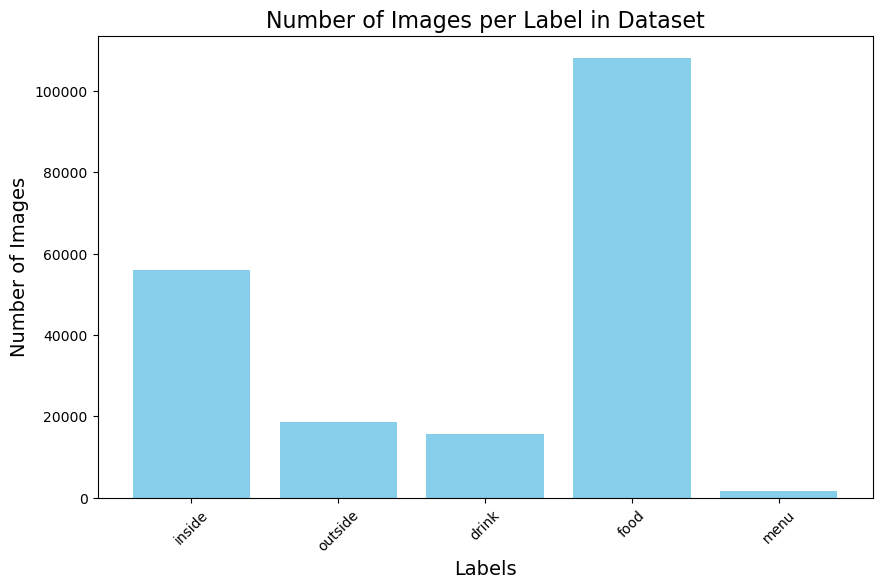

In [57]:
# Visualize the number of images per label
labels = list(label_to_photos.keys())
counts = [len(label_to_photos[label]) for label in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Number of Images per Label in Dataset', fontsize=16)
plt.xticks(rotation=45)
plt.show()


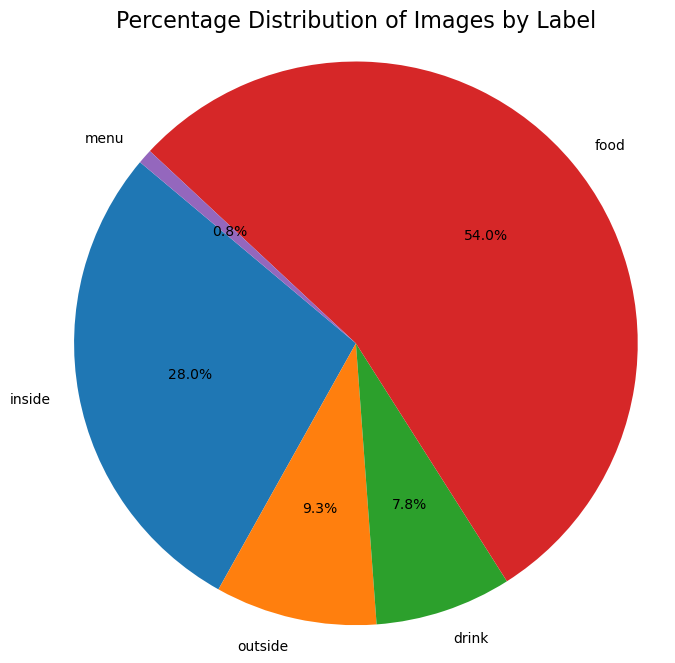

In [59]:
# Calculate percentage distribution of images per label
total_images = sum(counts)
percentages = [(count / total_images) * 100 for count in counts]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title("Percentage Distribution of Images by Label", fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

In [61]:
#Define the image preprocessing function
# Resize images to 64x64 and normalize pixel values to [-1, 1]
image_dir = r"D:\Photos" 
image_size = (64, 64)

In [63]:
# Function to preprocess the images
def preprocess_image(photo_id):
    # Load the image from the directory using the photo_id
    img_path = os.path.join(image_dir, f"{photo_id}.jpg")
    image = tf.io.read_file(img_path)  # Load the image file
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)  # Resize to 64x64
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

In [65]:
# Step 3: Create TensorFlow datasets for all labels
# We'll create a separate dataset for each label (e.g., "food", "drink", etc.)
datasets = {}
for label, photo_ids in label_to_photos.items():
    datasets[label] = tf.data.Dataset.from_tensor_slices(photo_ids)
    datasets[label] = datasets[label].map(preprocess_image).batch(128)

In [67]:
# Combine all datasets into one (optional, depends on the model's use case)
combined_dataset = tf.data.Dataset.sample_from_datasets(list(datasets.values())).shuffle(1000).batch(128)


In [69]:
# Define the DCGAN architecture
# Define the generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_shape=(100,)),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model


In [71]:
# Define the discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [73]:
# Instantiate the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()


In [75]:
#Define the loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [77]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [79]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [81]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [83]:
#Define the training step
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])  # Generate random noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Update weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [85]:
def filter_invalid_images(image):
    return image is not None

# Preprocess images and filter out invalid ones
food_images = tf.data.Dataset.from_tensor_slices(label_to_photos["food"])
food_images = food_images.map(preprocess_image)
food_images = food_images.filter(filter_invalid_images).batch(128)

In [87]:
invalid_files = []

def preprocess_image_with_logging(photo_id):
    try:
        img_path = os.path.join(image_dir, f"{photo_id}.jpg")
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = (image - 127.5) / 127.5
        return image
    except tf.errors.InvalidArgumentError:
        invalid_files.append(photo_id)
        return None

# Use the updated function
food_images = tf.data.Dataset.from_tensor_slices(label_to_photos["food"])
food_images = food_images.map(preprocess_image_with_logging)
food_images = food_images.filter(filter_invalid_images).batch(128)

# Print the invalid files
print("Invalid files:", invalid_files)


Invalid files: []


In [89]:
from PIL import Image

def validate_images(directory):
    invalid_files = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify the file is a valid image
        except Exception as e:
            print(f"Invalid image file: {filename}, Error: {e}")
            invalid_files.append(filename)
    return invalid_files

# Validate all files in the photos directory
invalid_files = validate_images(image_dir)
print("Invalid files:", invalid_files)


Invalid files: []


Deleting invalid because my system break-down every time and i have to perform this every time (Marmik)

In [91]:
# Delete invalid files after validation
for invalid_file in invalid_files:
    file_path = os.path.join(image_dir, invalid_file)
    try:
        os.remove(file_path)  # Delete the invalid file
        print(f"Deleted invalid file: {file_path}")
    except Exception as e:
        print(f"Error deleting file {file_path}: {e}")

In [93]:
# Apply the preprocessing function using the wrapper
datasets = {}
for label, photo_ids in label_to_photos.items():
    datasets[label] = tf.data.Dataset.from_tensor_slices(photo_ids)
    datasets[label] = datasets[label].map(preprocess_image_wrapper).batch(128)

# Combine all datasets into one
combined_dataset = tf.data.Dataset.sample_from_datasets(list(datasets.values())).shuffle(1000).batch(128)


NameError: name 'preprocess_image_wrapper' is not defined

In [95]:
# Debug resolved paths
for photo_id in label_to_photos["food"][:5]:  # Check for "food" label
    img_path = os.path.join(image_dir, f"{photo_id}.jpg")
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
    else:
        print(f"Resolved path: {img_path}")


Resolved path: D:\Photos\pve7D6NUrafHW3EAORubyw.jpg
Resolved path: D:\Photos\H52Er-uBg6rNrHcReWTD2w.jpg
Resolved path: D:\Photos\wZ29mUm6nKz566j17OBadw.jpg
Resolved path: D:\Photos\Le9rMdT8YFlvqr431LctIQ.jpg
Resolved path: D:\Photos\9kVdBkGWcKfCFzSwUXjQyw.jpg


In [97]:
# Visualize preprocessed images for each label
for label in labels:
    dataset = datasets[label]
    sample_images = next(iter(dataset))[:4]  # Take the first 8 images

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Preprocessed Images - {label.capitalize()}", fontsize=16)
    for i, img in enumerate(sample_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow((img.numpy() * 127.5 + 127.5).astype(np.uint8))  # Rescale to [0, 255]
        plt.axis('off')
    plt.tight_layout()
    plt.show()


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

In [ ]:
generator.summary()

In [ ]:
discriminator.summary()